# 概要
各種seq2seqモデルによる英→日の翻訳を行う。

このノートブックはそのうちのLSTMを使ったもの。

コーパスはYusuke Oda氏作成のsmall_parallel_enjaを使用します。
https://github.com/odashi/small_parallel_enja

処理の流れは以下の通り。

* 前処理
    1. 開始・終了トークンの付与
    2. 単語IDへの変換則を定義
    3. 文章を単語IDの列に変換。列の長さはコーパス内の最大の文章の長さに0埋めで揃える
    4. teacher forcingのため、target側の単語列の単語の位置を一つずらしたものを新たに作成
* モデルの定義
    1. ハイパーパラメータの定義
    2. encoderの定義
    3. decorderの定義
* 学習条件の定義と学習
* 学習結果の保存

モデルの可視化のため、pydotをインストールする

In [1]:
!pip install --user pydot

You should consider upgrading via the 'pip install --upgrade pip' command.


終了後一度kernel restartする

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8637183300087174387, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14140932922371192234
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3607747149602401627
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16570887996260716394
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

In [3]:
import keras
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# 前処理
通常、言語データを時系列データとして解析する際は、以下のようなステップをたどる
1. 文字列の読み込み
2. 単語単位への分解
3. 単語へのID割り振り
4. 単語列からIDの羅列への変換

今回のデータセットは単語単位への分解がすでに終わっているので省略できる。

In [4]:

# ユニコードファイルを ascii に変換
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = w.rstrip().strip()

    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
def create_dataset(path, num_examples):
    with open(path) as f:
        word_pairs = f.readlines()
    word_pairs = [preprocess_sentence(sentence) for sentence in word_pairs]

    return word_pairs[:num_examples]

In [6]:

# データの読み込み
path_train_en = 'small_parallel_enja/train.en'
path_train_ja = 'small_parallel_enja/train.ja'
en = create_dataset(path_train_en, None)
ja = create_dataset(path_train_ja, None)
print(en[-1])
print(ja[-1])

<start> he thought irritably . <end>
<start> 彼 は いらだ ち ながら 思 っ た 。 <end>


In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
def tokenize(lang):
    #これはなくす。
    #学習済みw2vをembeddingにつかうので
    lang_tokenizer = keras.preprocessing.text.Tokenizer(filters='', oov_token='<unk>')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [9]:
def load_dataset(path, num_examples=None):
    # クリーニングされた入力と出力のペアを生成
    lang = create_dataset(path, num_examples)

    tensor, lang_tokenizer = tokenize(lang)

    return tensor, lang_tokenizer

In [10]:
# 単語へのIDの割り振りとID列への変換
# このサイズのデータセットで実験
num_examples = None
input_tensor, inp_lang = load_dataset(path_train_en, num_examples)
target_tensor, targ_lang = load_dataset(path_train_ja, num_examples)
# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [11]:
max_length_targ

18

In [12]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [13]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor[0])

Input Language; index to word mapping
2 ----> <start>
6 ----> i
42 ----> can
20 ----> 't
151 ----> tell
137 ----> who
30 ----> will
727 ----> arrive
234 ----> first
4 ----> .
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
92 ----> 誰
14 ----> が
230 ----> 一番
7 ----> に
155 ----> 着
29 ----> く
22 ----> か
18 ----> 私
7 ----> に
5 ----> は
277 ----> 分か
38 ----> り
21 ----> ま
41 ----> せ
30 ----> ん
4 ----> 。
3 ----> <end>


teacher forcingのため、decoder_input_tensor_train、decoder_target_tensor_trainを作っておく

In [14]:
############データの加工がいる
encoder_input_tensor = input_tensor
decoder_input_tensor = target_tensor[:,:-1]
decoder_target_tensor = target_tensor[:,1:] #これでteacher forcingを実現

# モデルの定義

## ハイパーパラメータの定義

In [15]:
BUFFER_SIZE = len(input_tensor)
batch_size = 128
epochs = 20
steps_per_epoch = len(input_tensor)//batch_size
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

## encoderの定義
1. 入力された単語IDをembedding
2. LSTMでhidden stateに変換

In [16]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(max_length_inp,),name='encoder_input')
encoder_inputs_embedding = Embedding(input_dim=vocab_inp_size, output_dim=embedding_dim)(encoder_inputs)
encoder = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_embedding)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

## decoderの定義
1. 入力（decoder_input_tensor_trainを想定）をembedding
2. embeddingとencoderのstate_h, state_cをLSTMに入力
3. outputをDense+softmaxで単語ごとの確率に変換

In [17]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(max_length_targ-1,),name='decoder_input')
decoder_inputs_embedding  = Embedding(input_dim=vocab_tar_size, output_dim=embedding_dim)(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_embedding,
                                     initial_state=encoder_states)
decoder_dense = Dense(vocab_tar_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

上記を使ってモデルを構築

In [18]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

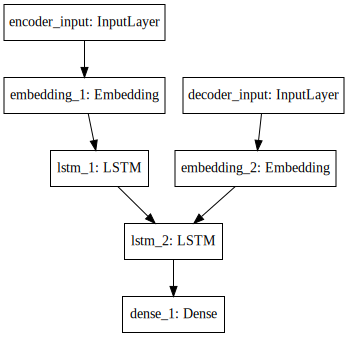

In [19]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18)           0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 18, 256)      1699328     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 17, 256)      2247168     decoder_input[0][0]              
__________________________________________________________________________________________________
lstm_1 (LS

# 学習条件の定義と学習

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

# define save condition
dir_path = 'saved_models/LSTM/'
save_every = 5
train_schedule = [save_every for i in range(divmod(epochs,save_every)[0])]
if divmod(epochs,save_every)[1] != 0:
    train_schedule += [divmod(epochs,save_every)[1]]
    
#run training
total_epochs = 0
for epoch in train_schedule:
    history = model.fit([encoder_input_tensor, decoder_input_tensor], 
                          np.apply_along_axis(lambda x: np_utils.to_categorical(x,num_classes=vocab_tar_size), 1, decoder_target_tensor),
                          batch_size=batch_size,
                          epochs=epoch,
                          validation_split=0.2)
    total_epochs += epoch
    filename = str(total_epochs) + 'epochs_LSTM.h5'
    model.save(dir_path+filename)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/5





40000/40000 [==============================] - 130s 3ms/step - loss: 2.9959 - acc: 0.4776 - val_loss: 2.3314 - val_acc: 0.5695
Epoch 2/5
40000/40000 [==============================] - 127s 3ms/step - loss: 2.1442 - acc: 0.5925 - val_loss: 2.0688 - val_acc: 0.6108
Epoch 3/5
40000/40000 [==============================] - 127s 3ms/step - loss: 1.8858 - acc: 0.6325 - val_loss: 1.8788 - val_acc: 0.6422
Epoch 4/5
40000/40000 [==============================] - 127s 3ms/step - loss: 1.6757 - acc: 0.6657 - val_loss: 1.7361 - val_acc: 0.6658
Epoch 5/5
40000/40000 [==============================] - 127s 3ms/step - loss: 1.5032 - acc: 0.6896 - val_loss: 1.6239 - val_acc: 0.6824


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 1024) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 1024) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 127s 3ms/step - loss: 1.3458 - acc: 0.7114 - val_loss: 1.5374 - val_acc: 0.6959
Epoch 2/5
40000/40000 [==============================] - 127s 3ms/step - loss: 1.2036 - acc: 0.7309 - val_loss: 1.4635 - val_acc: 0.7075
Epoch 3/5
40000/40000 [==============================] - 128s 3ms/step - loss: 1.0745 - acc: 0.7508 - val_loss: 1.4086 - val_acc: 0.7173
Epoch 4/5
40000/40000 [==============================] - 128s 3ms/step - loss: 0.9585 - acc: 0.7711 - val_loss: 1.3684 - val_acc: 0.7238
Epoch 5/5
40000/40000 [==============================] - 128s 3ms/step - loss: 0.8542 - acc: 0.7913 - val_loss: 1.3468 - val_acc: 0.7283
Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 127s 3ms/step - loss: 0.7599 - acc: 0.8103 - val_loss: 1.3254 - val_acc: 0.7331
Epoch 2/5
40000/40000 [==============================] - 127s 3ms/step - loss:

In [23]:
import json
with open(dir_path+str(total_epochs)+'epochs_LSTM.history', 'w') as file_pi:
    json.dump(history.history, file_pi)